# Obtaining dataset 

In [1]:
# import zipfile
# with zipfile.ZipFile("Dataset/BACH2018.zip","r") as zip_ref:
#     zip_ref.extractall()

# Importing necessary libraries


In [2]:
#  %pip install keras_applications

     |████████████████████████████████| 50 kB 2.3 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
len(tf.config.list_physical_devices('GPU'))

NameError: name 'tf' is not defined

In [3]:
import time
start = time.time()
import json
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,DenseNet201,InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import keras
from sklearn.cluster import KMeans

%matplotlib inline

In [23]:
tf.config.experimental.list_physical_devices('GPU') # 

[]

# Loading dataset images

In [11]:
# Transfer tif images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    '''
    1) Convert to RGB (but this was not done in code below)
    2) Resize image to 299 pixels (using OpenCV2)
    3) Convert to Array (using numpy)
    '''
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".tif":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))          
            # IMG.append(np.array(img))

            # EXTRACT TUMOR START
            ########################################################
            ###################################################
            p = 1;
            kernel = np.ones((7, 7), np.float32)/25
            img1 = cv2.filter2D(img, -1, kernel)
            # print("Gaussion Image")
            # cv2_imshow(img1)

            # Bilateral Filter for Edge Enhancement
            img2 = cv2.bilateralFilter(img1,9,75,75)
            # print("Bilateral Filter Image")
            # cv2_imshow(img3)


            # RGB to Gray conversion
            GRAY_Img = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
            # print("Grey Image") 
            # cv2_imshow(GRAY_Img)

            Data2Ext=GRAY_Img;
            # cv2.imwrite('ImageRedist.jpg',Data2Ext);

            # APPLY THRESHOLDING
            # ret,th1 = cv2.threshold(img2,127,255,cv2.THRESH_BINARY) # otsu
            # print("After thresholding Image")
            # cv2_imshow(th1);

            roi1=GRAY_Img;
            r,c=roi1.shape;
            if p==1:
                roi = roi1.reshape((roi1.shape[0] * roi1.shape[1], 1))

            # KMEANS clustering
            imgkmeans = KMeans(n_clusters=3, random_state=1); # why 3 clusters
            imgkmeans.fit(roi);
            label_values=imgkmeans.labels_;
            Label_reshped = np.reshape(label_values,(roi1.shape[0] ,roi1.shape[1]));

            segmentregions=roi1;
            # blobregions=roi1;

            rows,cols = roi1.shape;
            # Thresholding for segmentation
            for i in range(0,rows):
                for j in range(0,cols):
                    pixl=Label_reshped[i,j];
                    if pixl==0:
                        segmentregions[i,j]=255;
                
                    else:
                        segmentregions[i,j]=0;
            # print("Segmented Image")
            # cv2_imshow(segmentregions)

            # Thresholding for segmentation
            NewImage = Data2Ext;
            NewImage= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY);
            extractedregions=NewImage;

            for k in range(0,rows):
                for l in range(0,cols):
                    pixl1=segmentregions[k,l];
                    if pixl1==0:
                        extractedregions[k,l]=NewImage[k,l];
                    else:
                        extractedregions[k,l]=0;
            # print("Extracted Regions Image")
            # cv2_imshow(extractedregions)
            
            img = cv2.cvtColor(extractedregions,cv2.COLOR_GRAY2RGB)
            IMG.append(np.array(img))
        
    return IMG

IMG_SIZE = 224

benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

 25%|██▌       | 26/102 [00:34<00:31,  2.43it/s]/tmp/ipykernel_4385/2188498974.py:53: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  imgkmeans.fit(roi);
 75%|███████▌  | 77/102 [02:03<00:40,  1.63s/it]/tmp/ipykernel_4385/2188498974.py:53: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  imgkmeans.fit(roi);
 70%|███████   | 71/101 [02:03<00:55,  1.84s/it]/tmp/ipykernel_4385/2188498974.py:53: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  imgkmeans.fit(roi);
 78%|███████▊  | 79/101 [02:17<00:42,  1.91s/it]/tmp/ipykernel_4385/2188498974.py:53: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  imgkmeans.fit(roi);
100%|██████████| 101/101 [03:08<00:00,  1.86s/it]


In [10]:
# #Transfer tif images to an array IMG
# def Dataset_loader(DIR, RESIZE, sigmaX=10):
#   '''
#   1) Convert to RGB (but this was not done in code below)
#   2) Resize image to 227 pixels (using OpenCV2)
#   3) Convert to Array (using numpy)
#   '''
#   IMG = []
#   read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
#   for IMAGE_NAME in tqdm(os.listdir(DIR)):
#       PATH = os.path.join(DIR,IMAGE_NAME)
#       _, ftype = os.path.splitext(PATH)
#       if ftype == ".tif":

#           img = read(PATH)
          
#           img = cv2.resize(img, (RESIZE,RESIZE))
          
#           IMG.append(np.array(img))
#   return IMG

# IMG_SIZE = 227 # 224 for ResNet and 227 for AlexNet

# benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
# insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
# invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
# normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

100%|██████████| 101/101 [00:01<00:00, 67.20it/s]


# Creating labels for the dataset

In [12]:
# Cancer: Benign vs InSitu vs Invasive vs Normal
# Create labels
benign_label = np.zeros(len(benign_data))
insitu_label = np.ones(len(insitu_data))
invasive_label = np.full(len(invasive_data), 2)
normal_label = np.full(len(normal_data), 3)

# Merge data
X = np.concatenate((benign_data, insitu_data, invasive_data, normal_data), axis = 0)
Y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)

# Shuffle data
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

# To categorical
Y = to_categorical(Y, num_classes= 4)

# Split into train, validation and test datasets

In [13]:
'''
70% training
15% validation
15% testing

Validation to avoid overfitting.

Model is robust = when changing the training, testing & validation -> the performance doesn't change that much.
'''
x_train, X_remainder, y_train, Y_remainder = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=11
    )

x_val, x_test, y_val, y_test = train_test_split(
    X_remainder, Y_remainder, 
    train_size=0.5, 
    random_state=11
    )

# Displaying some images with their labels

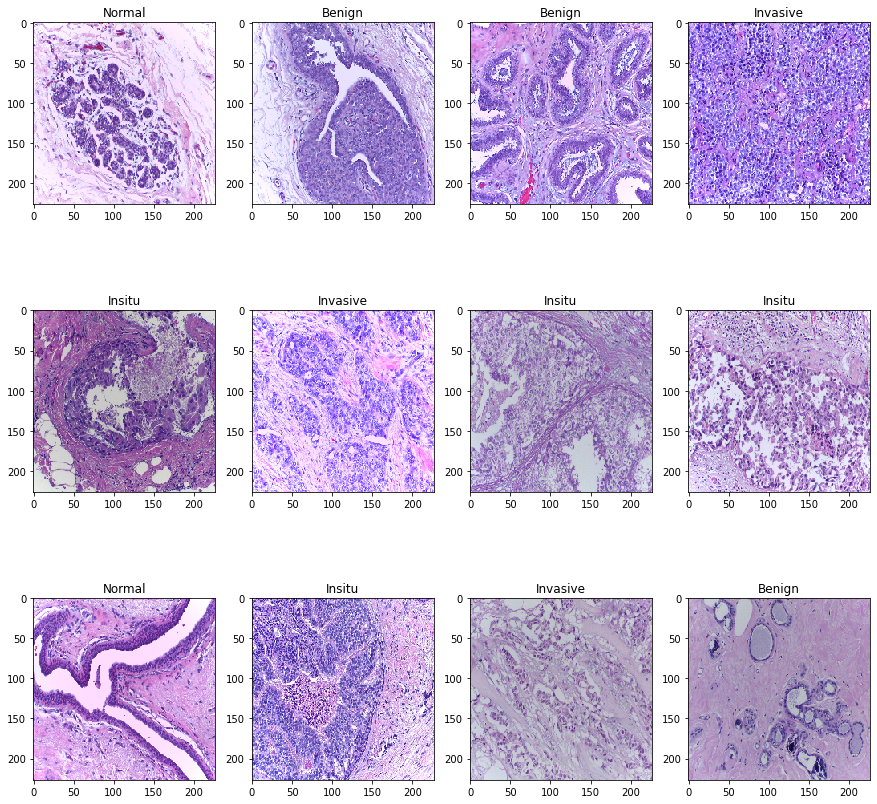

In [ ]:
# Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(y_train[i]) == 1:
        ax.title.set_text('Insitu')
    elif np.argmax(y_train[i]) == 2:
        ax.title.set_text('Invasive')
    else:
        ax.title.set_text('Normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Preprocessing - Data Augmentation

In [14]:
# DATA AUGMENTATION
img_height = IMG_SIZE
img_width = IMG_SIZE
batch_size = 32
input_shape = (img_width, img_height, 3)

# # Using original generator for data augmentation
train_generator = ImageDataGenerator(
        zoom_range = 2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images 
    )

# ResNet50

## Building model

In [15]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [17]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet, lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 7684      
                                                                 
Total params: 18,337,348
Trainable params: 18,104,452
No

In [18]:
# Learning Rate Reducer
'''
Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
'''
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
'''
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, 
so the model or weights can be loaded later to continue the training from the state saved.
'''
filepath="weights.best.hdf5" # can save to a specific folder
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Training and Evaluation

In [19]:
BATCH_SIZE = 32 # try with 16 & 32 - minibatch gradient descent

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/tmp/ipykernel_4385/3233926941.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
9/8 [==============================] - ETA: -1s - loss: 1.5985 - accuracy: 0.2750
Epoch 1: val_accuracy improved from -inf to 0.35000, saving model to weights.best.hdf5
8/8 [==============================] - 68s 6s/step - loss: 1.5985 - accuracy: 0.2750 - val_loss: 1.4637 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 2/20
9/8 [==============================] - ETA: -1s - loss: 1.4594 - accuracy: 0.3500
Epoch 2: val_accuracy improved from 0.35000 to 0.36667, saving model to weights.best.hdf5
8/8 [==============================] - 52s 6s/step - loss: 1.4594 - accuracy: 0.3500 - val_loss: 1.3548 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 3/20
9/8 [==============================] - ETA: -1s - loss: 1.4136 - accuracy: 0.3179
Epoch 3: val_accuracy did not improve from 0.36667
8/8 [==============================] - 51s 6s/step - loss: 1.4136 - accuracy: 0.3179 - val_loss: 1.3998 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 4/20
9/8 [==============================] - ETA: -1s - 

KeyboardInterrupt: 

<AxesSubplot:>

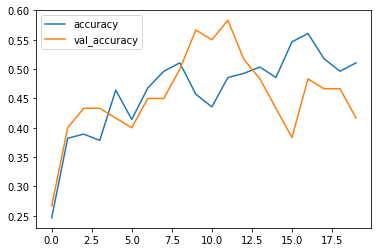

In [10]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()   

In [11]:
print(history_df.tail())

        loss  accuracy  val_loss  val_accuracy       lr
15  0.551271  0.546429  0.728474      0.383333  0.00010
16  0.543217  0.560714  0.775980      0.483333  0.00010
17  0.551705  0.517857  0.740921      0.466667  0.00002
18  0.547450  0.496429  0.739150      0.466667  0.00002
19  0.542377  0.510714  0.757689      0.416667  0.00002


<AxesSubplot:>

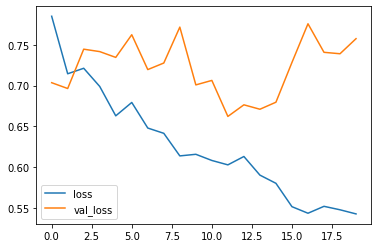

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

## K-Fold Cross Validation

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [14]:
# K FOLD (N=10), very low average accuracy
k = 5
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
prec_score = []
recall_score = []
f1_score = []

for train_index , test_index in kf.split(x_train):
    x_train_kf , x_test_kf = x_train[train_index],x_train[test_index]
    y_train_kf , y_test_kf = y_train[train_index] , y_train[test_index]
    y_test_kf = np.argmax(y_test_kf, axis=1) 
     
    model.fit(x_train_kf,y_train_kf)
    pred_values = model.predict(x_test_kf)
    pred_values=np.argmax(pred_values, axis=1)
    acc = accuracy_score(pred_values , y_test_kf)
    prec = precision_score(pred_values , y_test_kf, average='micro')
    report = classification_report(y_test_kf, pred_values) # NOTE: not used
    print(report)
    
    acc_score.append(acc)
    prec_score.append(prec)

     
avg_acc_score = sum(acc_score)/k
 
# print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))


2/2 [==============================] - 4s 631ms/step
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        14
           1       0.77      0.50      0.61        20
           2       0.54      0.88      0.67         8
           3       0.69      0.79      0.73        14

    accuracy                           0.64        56
   macro avg       0.64      0.68      0.64        56
weighted avg       0.67      0.64      0.64        56

2/7 [=======>......................] - ETA: 27s - loss: 0.4954 - accuracy: 0.6250

KeyboardInterrupt: 

# AlexNet

## Building model

In [ ]:
# first way
def build_alexnet_model():
  model = Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax') 
    ])
  model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
  model.summary()
  
  return model

In [ ]:
K.clear_session()
gc.collect()

model = build_alexnet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 58,303,236
Trainable params: 58,300,484
Non-trainable params: 2,752
_________________________________________________________________


In [ ]:
# Learning Rate Reducer
'''
Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
'''
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
'''
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, 
so the model or weights can be loaded later to continue the training from the state saved.
'''
filepath="weights.best.hdf5" # can save to a specific folder
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Training and Evaluation

In [ ]:
#Defining the parameters
batch_size= 100
epochs=50
learn_rate=.001

# history = model.fit_generator(
#     train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
#     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
#     epochs=50,
#     validation_data=(x_val, y_val),
#     callbacks=[tensorboard_cb]
# )
#Training the model

history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, 
                              steps_per_epoch = x_train.shape[0]//batch_size, 
                              validation_data = (x_val, y_val), 
                              validation_freq = 1, callbacks = [lrr, checkpoint], verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 2.8270 - accuracy: 0.3056
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to weights.best.hdf5
2/2 [==============================] - 7s 4s/step - loss: 2.8270 - accuracy: 0.3056 - val_loss: 18.0733 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 3.1085 - accuracy: 0.2700
Epoch 2: val_accuracy improved from 0.16667 to 0.36667, saving model to weights.best.hdf5
2/2 [==============================] - 6s 4s/step - loss: 3.1085 - accuracy: 0.2700 - val_loss: 5.3381 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 2.7213 - accuracy: 0.3056
Epoch 3: val_accuracy did not improve from 0.36667
2/2 [==============================] - 2s 863ms/step - loss: 2.7213 - accuracy: 0.3056 - val_loss: 3.8787 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 1.9967 - 

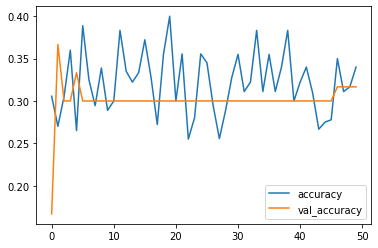

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()   

In [ ]:
print(history_df.tail())

        loss  accuracy  val_loss  val_accuracy            lr
45  2.473954  0.277778  1.328568      0.300000  1.000000e-07
46  2.523230  0.350000  1.318207      0.316667  1.000000e-07
47  2.319875  0.311111  1.308618      0.316667  1.000000e-07
48  2.384297  0.316667  1.298716      0.316667  1.000000e-07
49  2.638875  0.340000  1.289764      0.316667  1.000000e-07


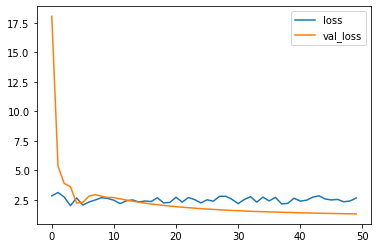

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

## K-Fold Cross Validation

# Prediction

In [ ]:
model.load_weights("weights.best.hdf5") # load the latest checkpoint weights
y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

0.75

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
y_pred_tta = np.mean(predictions, axis=0)

'''
Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, 
we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.
'''

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


'\nTest Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, \nwe will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.\n'

## Confusion Matrix

Confusion matrix, without normalization
[[ 8  0  2  4]
 [ 0 12  0  0]
 [ 0  3 11  3]
 [ 0  0  0 17]]


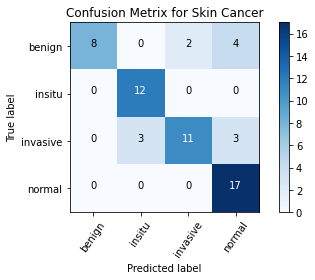

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'insitu', 'invasive', 'normal'] # later & try
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

## Classification Report

In [ ]:
# precision, recall (sensitivity), and accuracy
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.57      0.73        14
           1       0.80      1.00      0.89        12
           2       0.85      0.65      0.73        17
           3       0.71      1.00      0.83        17

    accuracy                           0.80        60
   macro avg       0.84      0.80      0.79        60
weighted avg       0.83      0.80      0.79        60



In [ ]:
print('Running time: %.4f seconds' % (time.time()-start))